https://docs.google.com/document/d/1qJaeuC4Fddou_Ts2Lea0UHjrzgy8aSzY6ACCvUwuTe4/edit

In [204]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

<h3>Data Preparation

In [205]:
#load and preprocess countries data
df_countries = pd.read_csv('countries_all.csv')
filtered_df_countries = (df_countries[df_countries['Time'] == 2020]
                         .rename(columns={'Country Name' : 'country', 
                                          'Time' : 'year', 
                                          'GDP per capita, PPP (current international $) [NY.GDP.PCAP.PP.CD]' : 'gdp', 
                                          'CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]' : 'co2'})
                         [['country', 'year', 'gdp', 'co2']])

#load and preprocess esg data
esg = pd.read_csv('esg.csv')
esg.replace('..', np.nan, inplace=True)
esg.dropna(inplace=True)

#load and preprocess culture data
cul = pd.read_csv('culture.csv')
cul.replace('#NULL!', np.nan, inplace=True)
cul.dropna(inplace=True)

#merge all dataframes
dfs = [filtered_df_countries, esg, cul]
combined_df = reduce(lambda left,right: pd.merge(left,right,on='country'), dfs)
for col in combined_df.columns[1:]:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

#sort values and reset index in-place
combined_df.sort_values('country', inplace=True)
combined_df.reset_index(drop=True, inplace=True)

#output
combined_df.head(5)


,country,year,gdp,co2,mean_of_esg,pdi,idv,mas,uai,ltowvs,ivr
0,Argentina,2020.0,20797.725953,3.405618,0.552,49,46,56,86,20,62
1,Australia,2020.0,53216.468537,14.776137,0.560,38,90,61,51,21,71
2,Austria,2020.0,57235.545869,6.632646,0.613,11,55,79,70,60,63
3,Bangladesh,2020.0,5904.567363,0.510648,0.532,80,20,55,60,47,20
4,Belgium,2020.0,54679.141805,7.398131,0.586,65,75,54,94,82,57


In [206]:
combined_df.describe()

,year,gdp,co2,mean_of_esg,pdi,idv,mas,uai,ltowvs,ivr
count,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,2020.0,38216.955744,5.192788,0.575854,56.958333,46.854167,48.395833,67.916667,48.000000,48.125000
std,0.0,24767.904096,3.157487,0.026567,20.959899,22.955081,19.623845,23.384695,21.027844,21.128407
min,2020.0,5284.664584,0.510648,0.516000,11.000000,13.000000,5.000000,8.000000,13.000000,0.000000
25%,2020.0,19434.663125,3.213631,0.553000,39.750000,26.750000,39.500000,50.750000,31.750000,30.750000
50%,2020.0,35135.711374,4.641445,0.579000,60.500000,46.000000,50.000000,70.000000,47.500000,48.000000
75%,2020.0,52533.084117,6.889976,0.595000,70.250000,68.250000,61.750000,86.000000,62.250000,65.250000
max,2020.0,119534.620916,14.776137,0.629000,104.000000,90.000000,95.000000,112.000000,88.000000,97.000000


<h5>Test for seasonal variations

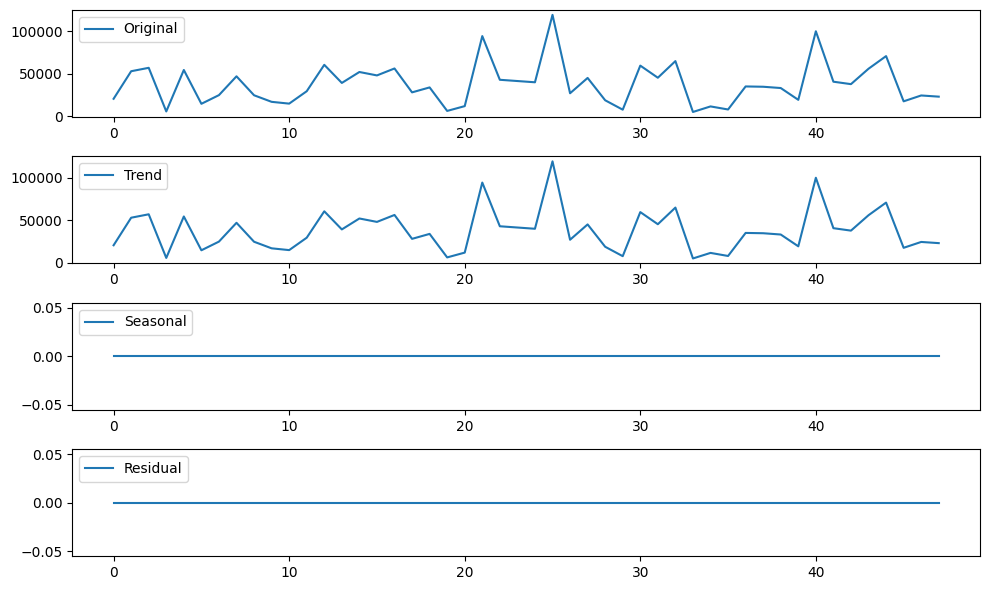

In [207]:
result = seasonal_decompose(combined_df['gdp'], model='additive', period=1)
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(combined_df['gdp'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<h5>Histogram to test if logs are needed

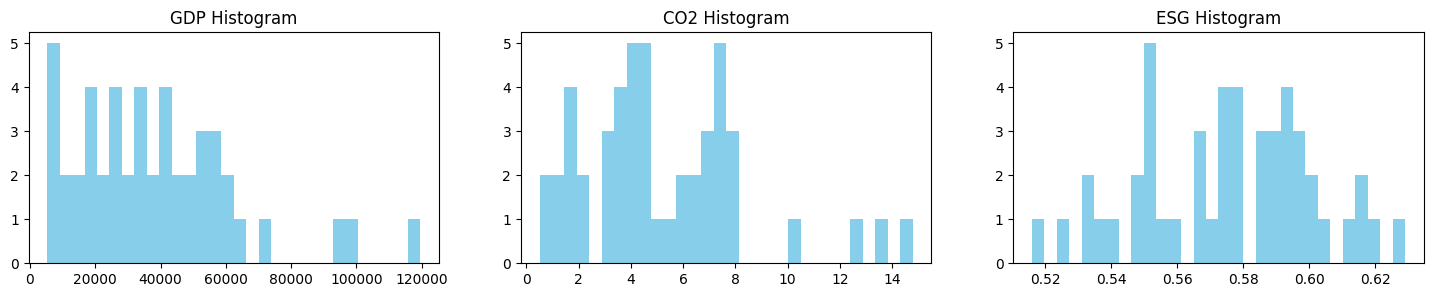

In [208]:
plt.figure(figsize=(18, 3))
plt.subplot(1, 3, 1)
plt.hist(combined_df['gdp'], bins=30, color='skyblue')
plt.title('GDP Histogram')
plt.subplot(1, 3, 2)
plt.hist(combined_df['co2'], bins=30, color='skyblue')
plt.title('CO2 Histogram')
plt.subplot(1, 3, 3)
plt.hist(combined_df['mean_of_esg'], bins=30, color='skyblue')
plt.title('ESG Histogram')
plt.show()

<h5>Boxplots to test if logs are needed

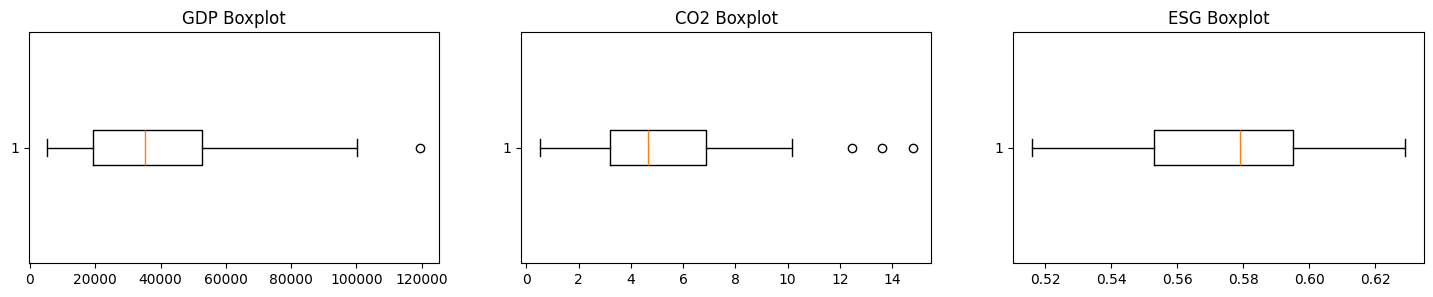

In [209]:
plt.figure(figsize=(18, 3))
plt.subplot(1, 3, 1)
plt.boxplot(combined_df['gdp'], vert=False)
plt.title('GDP Boxplot')
plt.subplot(1, 3, 2)
plt.boxplot(combined_df['co2'], vert=False)
plt.title('CO2 Boxplot')
plt.subplot(1, 3, 3)
plt.boxplot(combined_df['mean_of_esg'], vert=False)
plt.title('ESG Boxplot')
plt.show()

<h5>Calcultating Skewness for each variable

In [210]:
#Skewness test
skewness_results = {}
for column in combined_df.columns[2:5]:
    skewness_results[column] = skew(combined_df[column])
for variable, skewness_value in skewness_results.items():
    print(f"Skewness of {variable}: {skewness_value}")

#Shapiro test
shapiro_results = {}
for column in combined_df.columns[2:5]:
    stat, p_value = shapiro(combined_df[column])
    shapiro_results[column] = {'Statistic': stat, 'P-value': p_value}
for variable, results in shapiro_results.items():
    print(f"Shapiro P-value {variable}: {results['P-value']}")

Skewness of gdp: 1.1265217820963738
Skewness of co2: 1.0343439580075529
Skewness of mean_of_esg: -0.23462995591570063
Shapiro P-value gdp: 0.002279269276186824
Shapiro P-value co2: 0.0028381049633026123
Shapiro P-value mean_of_esg: 0.6339701414108276


<h5>Taking logs of CO2 and GDP

In [211]:
combined_df['log_gdp'] = np.log(combined_df['gdp'])
combined_df['log_co2'] = np.log(combined_df['co2'])
combined_df.head()

,country,year,gdp,co2,mean_of_esg,pdi,idv,mas,uai,ltowvs,ivr,log_gdp,log_co2
0,Argentina,2020.0,20797.725953,3.405618,0.552,49,46,56,86,20,62,9.942599,1.225426
1,Australia,2020.0,53216.468537,14.776137,0.560,38,90,61,51,21,71,10.882123,2.693014
2,Austria,2020.0,57235.545869,6.632646,0.613,11,55,79,70,60,63,10.954930,1.892004
3,Bangladesh,2020.0,5904.567363,0.510648,0.532,80,20,55,60,47,20,8.683481,-0.672076
4,Belgium,2020.0,54679.141805,7.398131,0.586,65,75,54,94,82,57,10.909238,2.001227


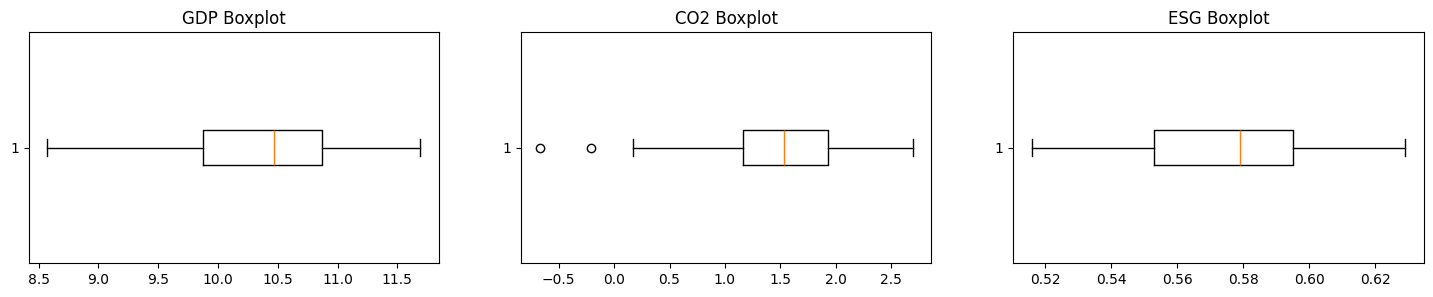

In [212]:
plt.figure(figsize=(18, 3))
plt.subplot(1, 3, 1)
plt.boxplot(combined_df['log_gdp'], vert=False)
plt.title('GDP Boxplot')
plt.subplot(1, 3, 2)
plt.boxplot(combined_df['log_co2'], vert=False)
plt.title('CO2 Boxplot')
plt.subplot(1, 3, 3)
plt.boxplot(combined_df['mean_of_esg'], vert=False)
plt.title('ESG Boxplot')
plt.show()

In [213]:
#Skewness test
skewness_results = {}
for column in combined_df.columns[11:]:
    skewness_results[column] = skew(combined_df[column])
for variable, skewness_value in skewness_results.items():
    print(f"Skewness of {variable}: {skewness_value}")

#Shapiro test
shapiro_results = {}
for column in combined_df.columns[11:]:
    stat, p_value = shapiro(combined_df[column])
    shapiro_results[column] = {'Statistic': stat, 'P-value': p_value}
for variable, results in shapiro_results.items():
    print(f"Shapiro P-value {variable}: {results['P-value']}")

Skewness of log_gdp: -0.608135027686305
Skewness of log_co2: -0.804045466261342
Shapiro P-value log_gdp: 0.07516957074403763
Shapiro P-value log_co2: 0.02842302806675434


<h3>Kuznets OLS

In [214]:
combined_df['log_gdp_squared'] = combined_df['log_gdp']**2
formula = 'log_co2 ~ log_gdp + log_gdp_squared'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     43.87
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           2.69e-11
Time:                        15:18:10   Log-Likelihood:                -25.354
No. Observations:                  48   AIC:                             56.71
Df Residuals:                      45   BIC:                             62.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -29.7381      9.476     

<h3>EKC, ESG Linear representation

In [215]:
formula = 'log_co2 ~ mean_of_esg + log_gdp'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     43.23
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           3.35e-11
Time:                        15:18:10   Log-Likelihood:                -25.588
No. Observations:                  48   AIC:                             57.18
Df Residuals:                      45   BIC:                             62.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.7041      1.396     -2.654      

<h3>EKC, ESG Quadratic representation

In [216]:
formula = 'log_co2 ~ mean_of_esg + log_gdp + log_gdp_squared'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     40.09
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           1.20e-12
Time:                        15:18:10   Log-Likelihood:                -19.701
No. Observations:                  48   AIC:                             47.40
Df Residuals:                      44   BIC:                             54.89
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -33.4126      8.586     

<h3>EKC, ESG Log transformation

In [217]:
formula = 'co2 ~ mean_of_esg + log_gdp'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     22.14
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           2.02e-07
Time:                        15:18:11   Log-Likelihood:                -106.35
No. Observations:                  48   AIC:                             218.7
Df Residuals:                      45   BIC:                             224.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.3334      7.509     -0.710      

<h3>Culture, EKC, ESG

<h6>CULTURE = Power

In [218]:
combined_df['log_gdp_x_pdi'] = combined_df['log_gdp'] * combined_df['pdi']
formula = 'log_co2 ~ mean_of_esg + log_gdp_x_pdi'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     7.708
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00132
Time:                        15:18:12   Log-Likelihood:                -44.245
No. Observations:                  48   AIC:                             94.49
Df Residuals:                      45   BIC:                             100.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.6787      2.500     -2.672

<h6>CULTURE = Individualism

In [219]:
combined_df['log_gdp_x_idv'] = combined_df['log_gdp'] * combined_df['idv']
formula = 'log_co2 ~ mean_of_esg + log_gdp_x_idv'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     10.30
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000207
Time:                        15:18:12   Log-Likelihood:                -42.269
No. Observations:                  48   AIC:                             90.54
Df Residuals:                      45   BIC:                             96.15
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.5571      2.373     -1.499

<h6>CULTURE = Masculinity

In [220]:
combined_df['log_gdp_x_mas'] = combined_df['log_gdp'] * combined_df['mas']
formula = 'log_co2 ~ mean_of_esg + log_gdp_x_mas'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     10.27
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000212
Time:                        15:18:13   Log-Likelihood:                -42.292
No. Observations:                  48   AIC:                             90.58
Df Residuals:                      45   BIC:                             96.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -7.2654      1.965     -3.697

<h6>CULTURE = Uncertainty

In [221]:
combined_df['log_gdp_x_uai'] = combined_df['log_gdp'] * combined_df['uai']
formula = 'log_co2 ~ mean_of_esg + log_gdp_x_uai'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     7.749
Date:                Thu, 29 Feb 2024   Prob (F-statistic):            0.00128
Time:                        15:18:13   Log-Likelihood:                -44.213
No. Observations:                  48   AIC:                             94.43
Df Residuals:                      45   BIC:                             100.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.3334      1.987     -3.187

<h6>CULTURE = Long-term Orientation

In [222]:
combined_df['log_gdp_x_ltowvs'] = combined_df['log_gdp'] * combined_df['ltowvs']
formula = 'log_co2 ~ mean_of_esg + log_gdp_x_ltowvs'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     8.521
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000728
Time:                        15:18:14   Log-Likelihood:                -43.608
No. Observations:                  48   AIC:                             93.22
Df Residuals:                      45   BIC:                             98.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.6165      2.067  

<h6>CULTURE = Indulgence

In [223]:
combined_df['log_gdp_x_ivr'] = combined_df['log_gdp'] * combined_df['ivr']
formula = 'log_co2 ~ mean_of_esg + log_gdp_x_ivr'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     9.364
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           0.000398
Time:                        15:18:14   Log-Likelihood:                -42.964
No. Observations:                  48   AIC:                             91.93
Df Residuals:                      45   BIC:                             97.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.3885      2.028     -2.657

<h3>Cluster Analysis

In [224]:
combined_df['log_gdp_x_ivr'] = combined_df['log_gdp'] * combined_df['ivr']
formula = 'log_co2 ~ mean_of_esg + log_gdp + log_gdp_x_ivr'
model = smf.ols(formula, data=combined_df)
ols = model.fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                log_co2   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     28.22
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           2.48e-10
Time:                        15:18:14   Log-Likelihood:                -25.566
No. Observations:                  48   AIC:                             59.13
Df Residuals:                      44   BIC:                             66.62
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.7676      1.447     -2.604